## Dataset Overview

The dataset is sourced from Roboflow (Hard Hat v10) and provided in COCO format.
Initial inspection was conducted using a standalone script (`inspect_data.py`)
to understand dataset structure before conversion.

### Key Statistics (Training Split)
- Images: 4,916
- Total annotations: 18,981
- Original classes:
  - Workers
  - person
  - head
  - helmet

### Class Selection Decision
The `Workers` class was removed due to semantic overlap with the `person` class.
Such overlap can introduce label ambiguity and negatively affect detector
convergence. The final set of classes used in this project is:

- person
- head
- helmet


In [1]:
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np

## Class Distribution Analysis

We analyze the distribution of object instances (bounding boxes) per class
in the training split. This provides insight into class imbalance, which is
common in PPE detection datasets.

Note:
- This analysis counts object instances, not images.
- An image may contain multiple objects from the same or different classes.


In [2]:
LABEL_DIR = Path("../data_yolo/train/labels")

class_counter = Counter()

for label_file in LABEL_DIR.glob("*.txt"):
    with open(label_file) as f:
        for line in f:
            cls_id = int(line.split()[0])
            class_counter[cls_id] += 1

class_counter


Counter({2: 13919, 1: 4612, 0: 450})

### Interpretation

The class distribution reveals a strong imbalance:

- `helmet` objects dominate the dataset
- `head` objects appear moderately frequently
- `person` objects are relatively sparse

This imbalance is expected in PPE datasets, where safety equipment may be
annotated independently of the full human body.

Modern detectors such as YOLOv8 employ focal loss and multi-scale feature
learning, which mitigates the impact of class imbalance. Therefore, no
explicit rebalancing is applied at this stage. The imbalance is documented
and monitored during training and evaluation.


## Object Size Distribution

Understanding object sizes is critical in object detection tasks, as small
objects are more sensitive to blur, low-light conditions, and resolution
changes.

We analyze bounding box areas relative to image size to characterize:
- The prevalence of small objects (e.g., helmets)
- Whether higher input resolutions are necessary


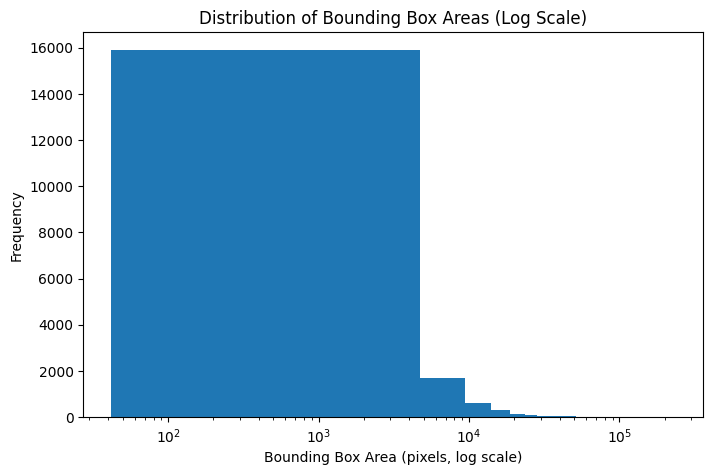

In [3]:
IMG_DIR = Path("../data_yolo/train/images")

bbox_areas = []

for label_file in LABEL_DIR.glob("*.txt"):
    img_path = IMG_DIR / (label_file.stem + ".jpg")
    img = cv2.imread(str(img_path))
    if img is None:
        continue

    h, w = img.shape[:2]

    with open(label_file) as f:
        for line in f:
            _, xc, yc, bw, bh = map(float, line.split())
            box_area = (bw * w) * (bh * h)
            bbox_areas.append(box_area)

plt.figure(figsize=(8, 5))
plt.hist(bbox_areas, bins=50)
plt.xscale("log")
plt.xlabel("Bounding Box Area (pixels, log scale)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Areas (Log Scale)")
plt.show()



### Interpretation

The bounding box area distribution shows that the majority of objects are
small relative to the full image size. This is particularly true for helmets,
which often occupy a small pixel region.

This observation supports the following design decisions:
- Using an input image size of 640×640 pixels
- Avoiding aggressive downscaling
- Expecting performance degradation under motion blur and low-light conditions

These findings justify the later focus on robustness and enhancement techniques.


## Visual Sanity Check of Bounding Boxes

Before training detection models, it is essential to visually verify that:
- Bounding boxes are correctly positioned
- Coordinates were converted correctly
- Class labels align with objects

This step helps catch silent errors that may not appear in training logs.


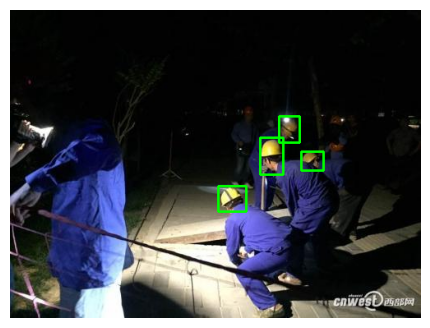

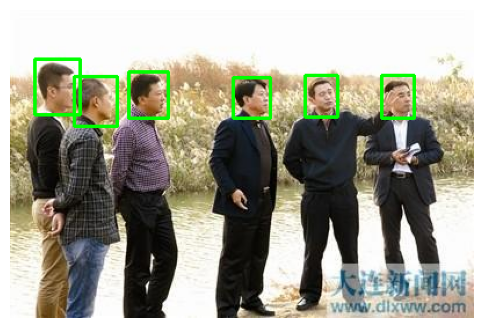

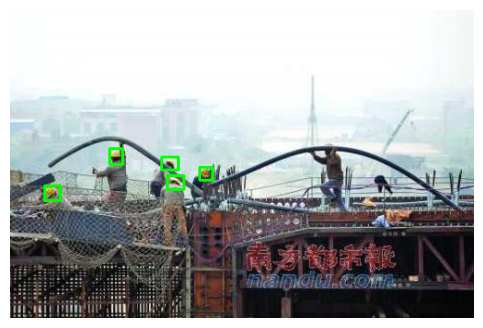

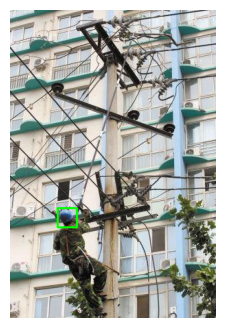

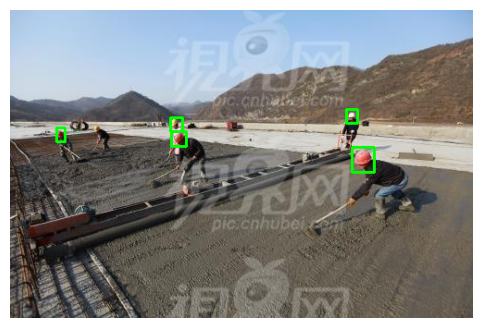

In [4]:
# Visualize random samples with bounding boxes
SAMPLES = 5

image_files = list(IMG_DIR.glob("*.jpg"))
sample_imgs = random.sample(image_files, SAMPLES)

for img_path in sample_imgs:
    label_path = LABEL_DIR / (img_path.stem + ".txt")
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    if not label_path.exists():
        continue

    with open(label_path) as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())
            x1 = int((xc - bw / 2) * w)
            y1 = int((yc - bh / 2) * h)
            x2 = int((xc + bw / 2) * w)
            y2 = int((yc + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


### Verification Outcome

Visual inspection confirms that:
- Bounding boxes align correctly with target objects
- Class assignments appear consistent
- No systematic conversion errors are present

The dataset is therefore deemed suitable for training object detection models.


## EDA Conclusions

Based on this exploratory analysis:

- The dataset exhibits class imbalance typical of PPE detection tasks
- Objects of interest are predominantly small
- Bounding box annotations are correctly formatted and aligned
- An input resolution of 640×640 is appropriate
- No manual image resizing or class rebalancing is applied

These findings inform the baseline training and robustness experiments that
follow in subsequent stages of the project.


In [5]:
print(f"Image resolution: {w} x {h} (width x height)")

Image resolution: 500 x 333 (width x height)
